<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w1_webinar_live.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AML 23/24 Webinar Week 1

* Key Points:
    - Essential, useful concept of ensembling: we can get a collection of diverse models (performing similarly) to work as a unit, performing better than the individuals.

    - Bagging (bootstrap aggregation) is one approach to ensembling; typically, used with decision trees. Key idea: build models on random samples of features/observations; models will pay attention to different regions of the data; averaging them out will give a better model

    - We can get off-the-shelf bagging with **Random Forests**: implemented and offered as any other model in `sklearn` and similar.

    - Random Forests address issues typically shown by individual decision trees: high variance; trade off: better performance with an ensemble, but giving away the interpretability aspect.


* Exercise:
    - Can we do the usual workflow - train, tune, evaluate - with Random Forests on a typical classification dataset (`titanic`)?

## Importing and Configuring

In [ ]:
# if we want to use a TargetEncoder, we will need to install `category_encoders`
# or update Colab's version of sklearn
# We probably need to restart the kernel

# !pip install category_encoders -q
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 19.4 MB/s eta 0:00:00


In [ ]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestClassifier

## The Dataset

* I am not going to do a train/test split here; there is separate test for the titanic data somewhere, which I could always retrieve later; I'll rely on cross validation for our model evaluation.

In [ ]:
tc = pd.read_csv(
    'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/titanic.csv'
)
tc.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


## Data Preparation

In [ ]:
# feature/target split and feature selection
target = 'Survived'
cat_feat = ['Pclass', 'Sex', 'Embarked']
num_feat = ['Age', 'SibSp', 'Parch', 'Fare']

In [ ]:
X = tc[ cat_feat + num_feat ]
y = tc[target]

In [ ]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

In [ ]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse_output=False, drop='if_binary')),
    ]
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_feat),
        ("cat", categorical_transformer, cat_feat),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 ['Pclass', 'Sex', 'Embarked'])])

## A Default Random Forest (Pipeline)

In [ ]:
clf = Pipeline(
    steps=[
        ("pp", preprocessor),
        ("clf", RandomForestClassifier())
    ]
)

In [ ]:
clf

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('clf', RandomForestClassifier())])

In [ ]:
clf.fit(X, y)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('clf', RandomForestClassifier())])

In [ ]:
# cross_val_score?
# I am going to use a more flexible version of it:
# * I want to see the scores on the training data as well
# * I would like to obtain stratified train/test data

In [ ]:
eval_results = cross_validate(
    clf, X, y, cv=5,
    scoring='balanced_accuracy',
    return_train_score=True
)

In [ ]:
eval_results

{'fit_time': array([0.21463251, 0.38596511, 0.32487202, 0.21812201, 0.20354152]),
 'score_time': array([0.02396011, 0.03226137, 0.01964116, 0.01892495, 0.01872015]),
 'test_score': array([0.77140975, 0.78475936, 0.84986631, 0.75708556, 0.83433054]),
 'train_score': array([0.98262368, 0.9863201 , 0.98335633, 0.9819846 , 0.97897103])}

In [ ]:
# for stratified sampling...
# ...create a custom cross-validation strategy
from sklearn.model_selection import StratifiedKFold

In [ ]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
eval_results = cross_validate(
    clf, X, y, cv=stratified_cv,
    scoring='balanced_accuracy',
    return_train_score=True
)

In [ ]:
eval_results

{'fit_time': array([0.21864009, 0.47904563, 0.44239354, 0.22185516, 0.22900128]),
 'score_time': array([0.02534151, 0.03406429, 0.02320933, 0.03697324, 0.02592683]),
 'test_score': array([0.79967062, 0.79772727, 0.81804813, 0.7802139 , 0.76984444]),
 'train_score': array([0.97782172, 0.9819846 , 0.98312356, 0.97902083, 0.9874334 ])}

## A Tweaked Random Forest (Pipeline)

In [ ]:
clf = Pipeline(
    steps=[
        ("pp", preprocessor),
        ("clf", RandomForestClassifier(
            max_depth=6
        ))
    ]
)

In [ ]:
clf

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('clf', RandomForestClassifier(max_depth=6))])

In [ ]:
clf.fit(X, y)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('clf', RandomForestClassifier(max_depth=6))])

In [ ]:
eval_results = cross_validate(
    clf, X, y, cv=stratified_cv,
    scoring='balanced_accuracy',
    return_train_score=True
)

In [ ]:
eval_results

{'fit_time': array([0.20605254, 0.18929148, 0.18880892, 0.18563461, 0.20679593]),
 'score_time': array([0.01959562, 0.02086163, 0.02104259, 0.01983142, 0.02129388]),
 'test_score': array([0.82509881, 0.8092246 , 0.81938503, 0.75989305, 0.75581705]),
 'train_score': array([0.83664172, 0.83282759, 0.85061021, 0.84356866, 0.84855977])}

In [ ]:
eval_results['test_score'].mean()

0.7938837067263356

In [ ]:
eval_results['train_score'].mean()

0.8424415919337189

## Grid-Searching a Better Random Forest

In [ ]:
clf = Pipeline(
    steps=[
        ("pp", preprocessor),
        ("clf", RandomForestClassifier())
    ]
)

In [ ]:
my_rf_grid = dict(
    clf__max_depth=[4, 5, 6, 7]
)

In [ ]:
list(ParameterGrid(my_rf_grid))

[{'clf__max_depth': 4},
 {'clf__max_depth': 5},
 {'clf__max_depth': 6},
 {'clf__max_depth': 7}]

In [ ]:
gs_cv = GridSearchCV(
    clf, my_rf_grid,
    cv=stratified_cv,
    scoring='balanced_accuracy',
    return_train_score=True
)

In [ ]:
gs_results = gs_cv.fit(X, y)

In [ ]:
gs_df = pd.DataFrame(gs_results.cv_results_)

In [ ]:
gs_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.184492,0.006983,0.017355,0.000148,4,{'clf__max_depth': 4},0.825099,0.797326,0.797326,0.775267,...,0.784902,0.031899,4,0.792239,0.799087,0.808432,0.813686,0.819322,0.806553,0.009778
1,0.183668,0.005426,0.018220,0.000777,5,{'clf__max_depth': 5},0.822398,0.827406,0.812032,0.758155,...,0.792263,0.035474,2,0.809862,0.812534,0.815498,0.834910,0.829362,0.820433,0.009877
2,0.192275,0.005428,0.018890,0.000491,6,{'clf__max_depth': 6},0.813307,0.809225,0.819385,0.750802,...,0.787872,0.032156,3,0.834318,0.835791,0.851076,0.849949,0.859549,0.846137,0.009649
3,0.194656,0.004017,0.022371,0.004590,7,{'clf__max_depth': 7},0.825099,0.821123,0.810294,0.774599,...,0.798450,0.025791,1,0.869809,0.877529,0.875925,0.877762,0.879695,0.876144,0.003386


In [ ]:
gs_df[ [
    'param_clf__max_depth',
    'mean_train_score', 'mean_test_score',
    'std_train_score', 'std_test_score', 'rank_test_score'
] ].sort_values('rank_test_score')

,param_clf__max_depth,mean_train_score,mean_test_score,std_train_score,std_test_score,rank_test_score
3,7,0.876144,0.798450,0.003386,0.025791,1
1,5,0.820433,0.792263,0.009877,0.035474,2
2,6,0.846137,0.787872,0.009649,0.032156,3
0,4,0.806553,0.784902,0.009778,0.031899,4


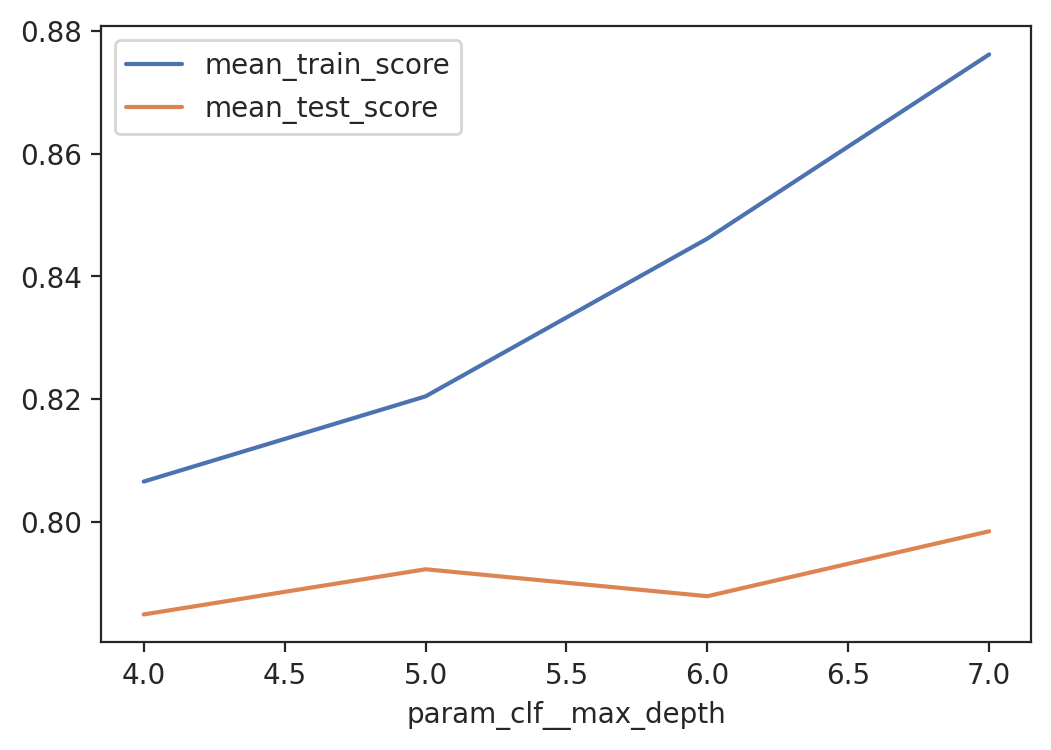

In [ ]:
gs_df.set_index('param_clf__max_depth')[['mean_train_score', 'mean_test_score']].plot.line();

## Further Work

* There are other hyper-parameters and ranges of values to be tried...

* One can use `RandomizedSearchCV` for sampling the number of configurations.

* The comparison with a grid-searched individual decision tree.

* Some features have not been used, others could be have engineered...

* Would different categorical encoding and missing value imputation strategies improved our model? TargetEncoding, KNN Imputation, among others.